<a href="https://colab.research.google.com/github/Anagh-Kansra/MACHINE-LEARNING-APPROACH-TO-ESTIMATE-HEALTH-OF-EV-BATTERY/blob/main/Copy_of_B05_S0C%24SoH%24SoF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. IMPORTING LIBRARIES

In [ ]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping

from sklearn import preprocessing

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline

#2. LOADING DATASET AS DATAFRAME --- battery

In [ ]:
battery = pd.read_csv('/content/B05_discharge_soc.csv')

In [ ]:
battery

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,Capacity,Cycle,SoC
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487,1,0.928244
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487,1,0.928244
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487,1,0.928244
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487,1,0.928244
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487,1,0.928244
...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312,1.325079,168,0.662540
50281,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062,1.325079,168,0.662540
50282,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828,1.325079,168,0.662540
50283,3.587336,0.001219,34.565580,0.0006,0.000,2810.640,1.325079,168,0.662540


In [ ]:
battery['charge_current']=abs(battery['charge_current'])

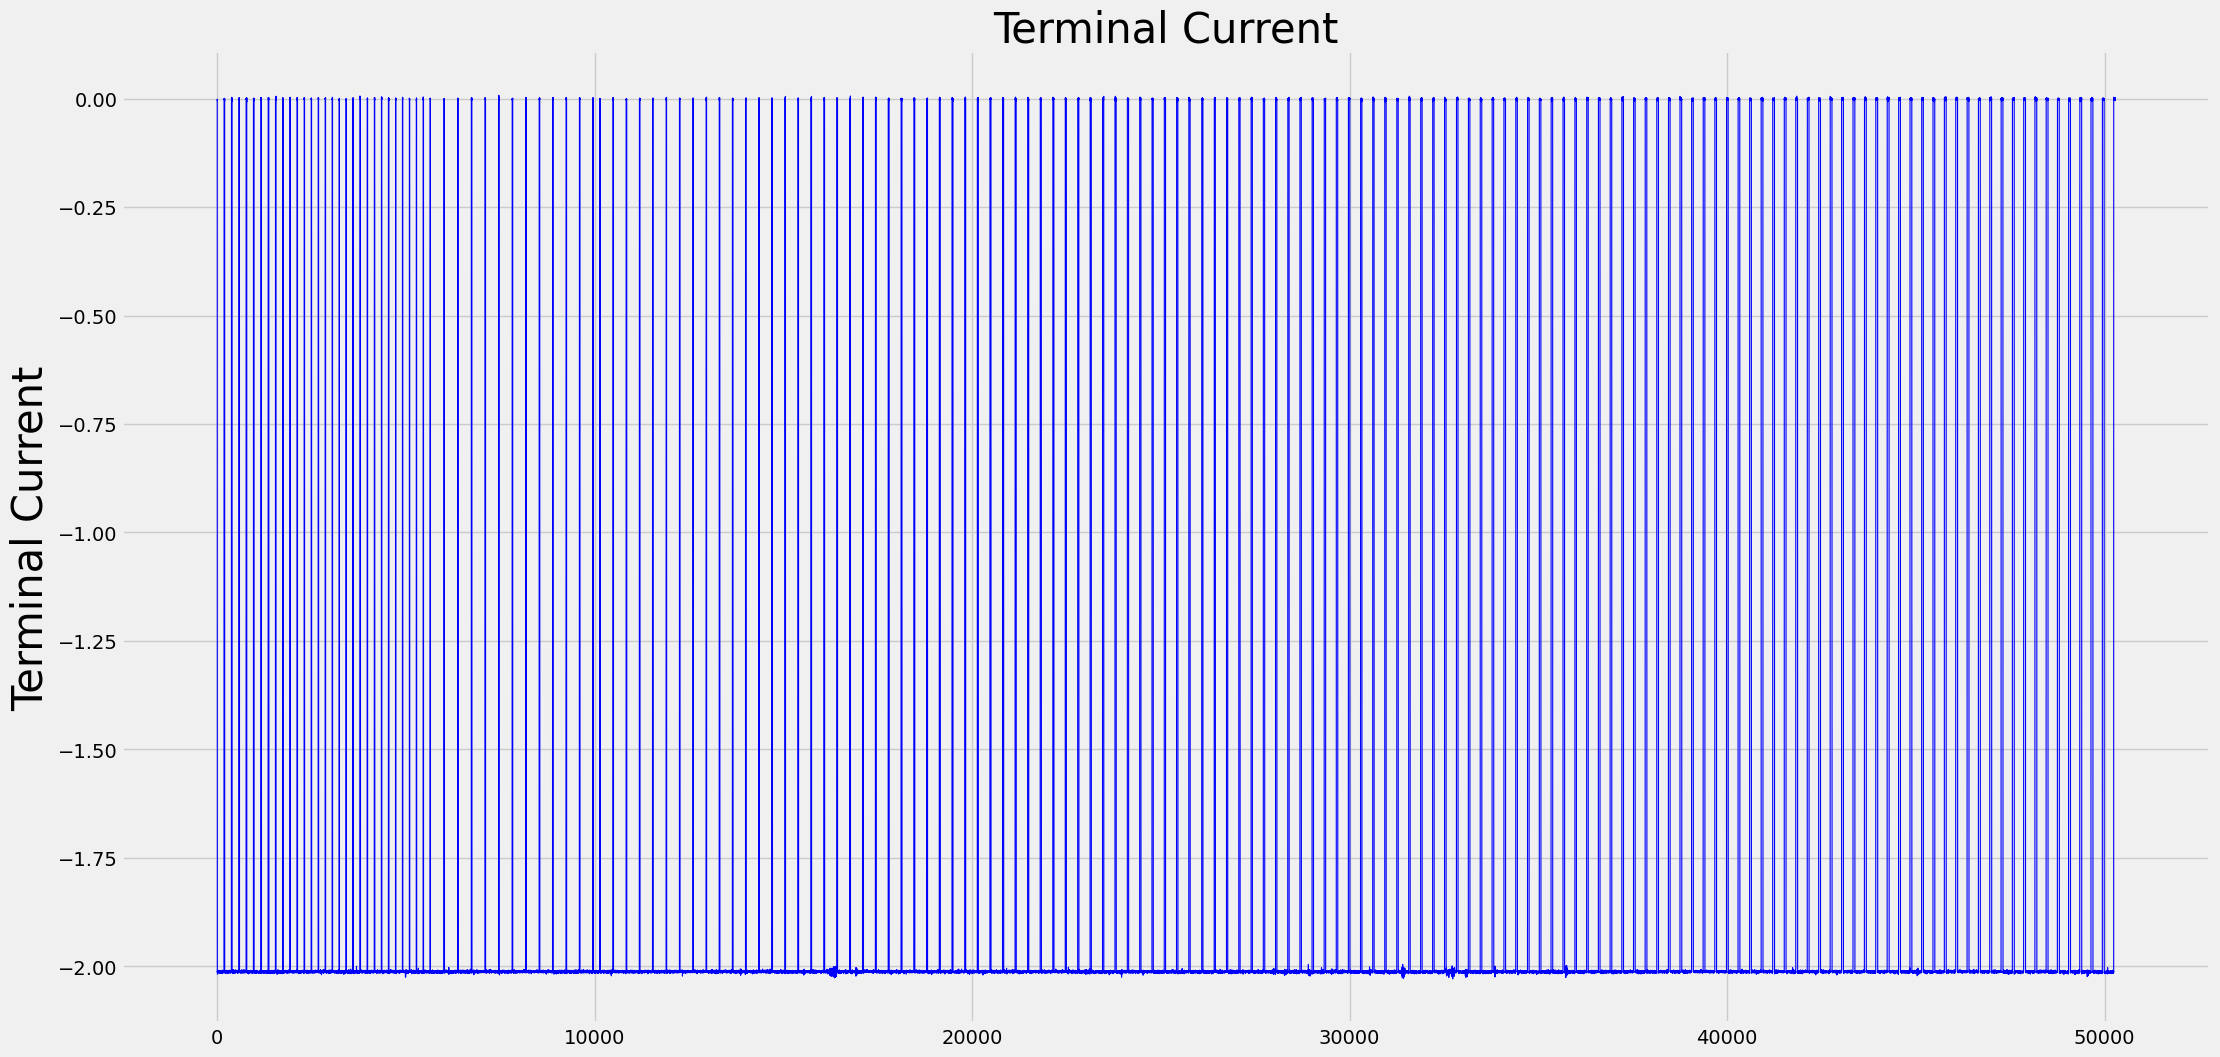

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(24,12))
plt.title("Terminal Current",fontsize=30)
sns.set(style="dark")
plt.ylabel('Terminal Current', fontsize=30)
plt.plot(battery['terminal_current'],color='blue',linewidth=0.8)
plt.show()

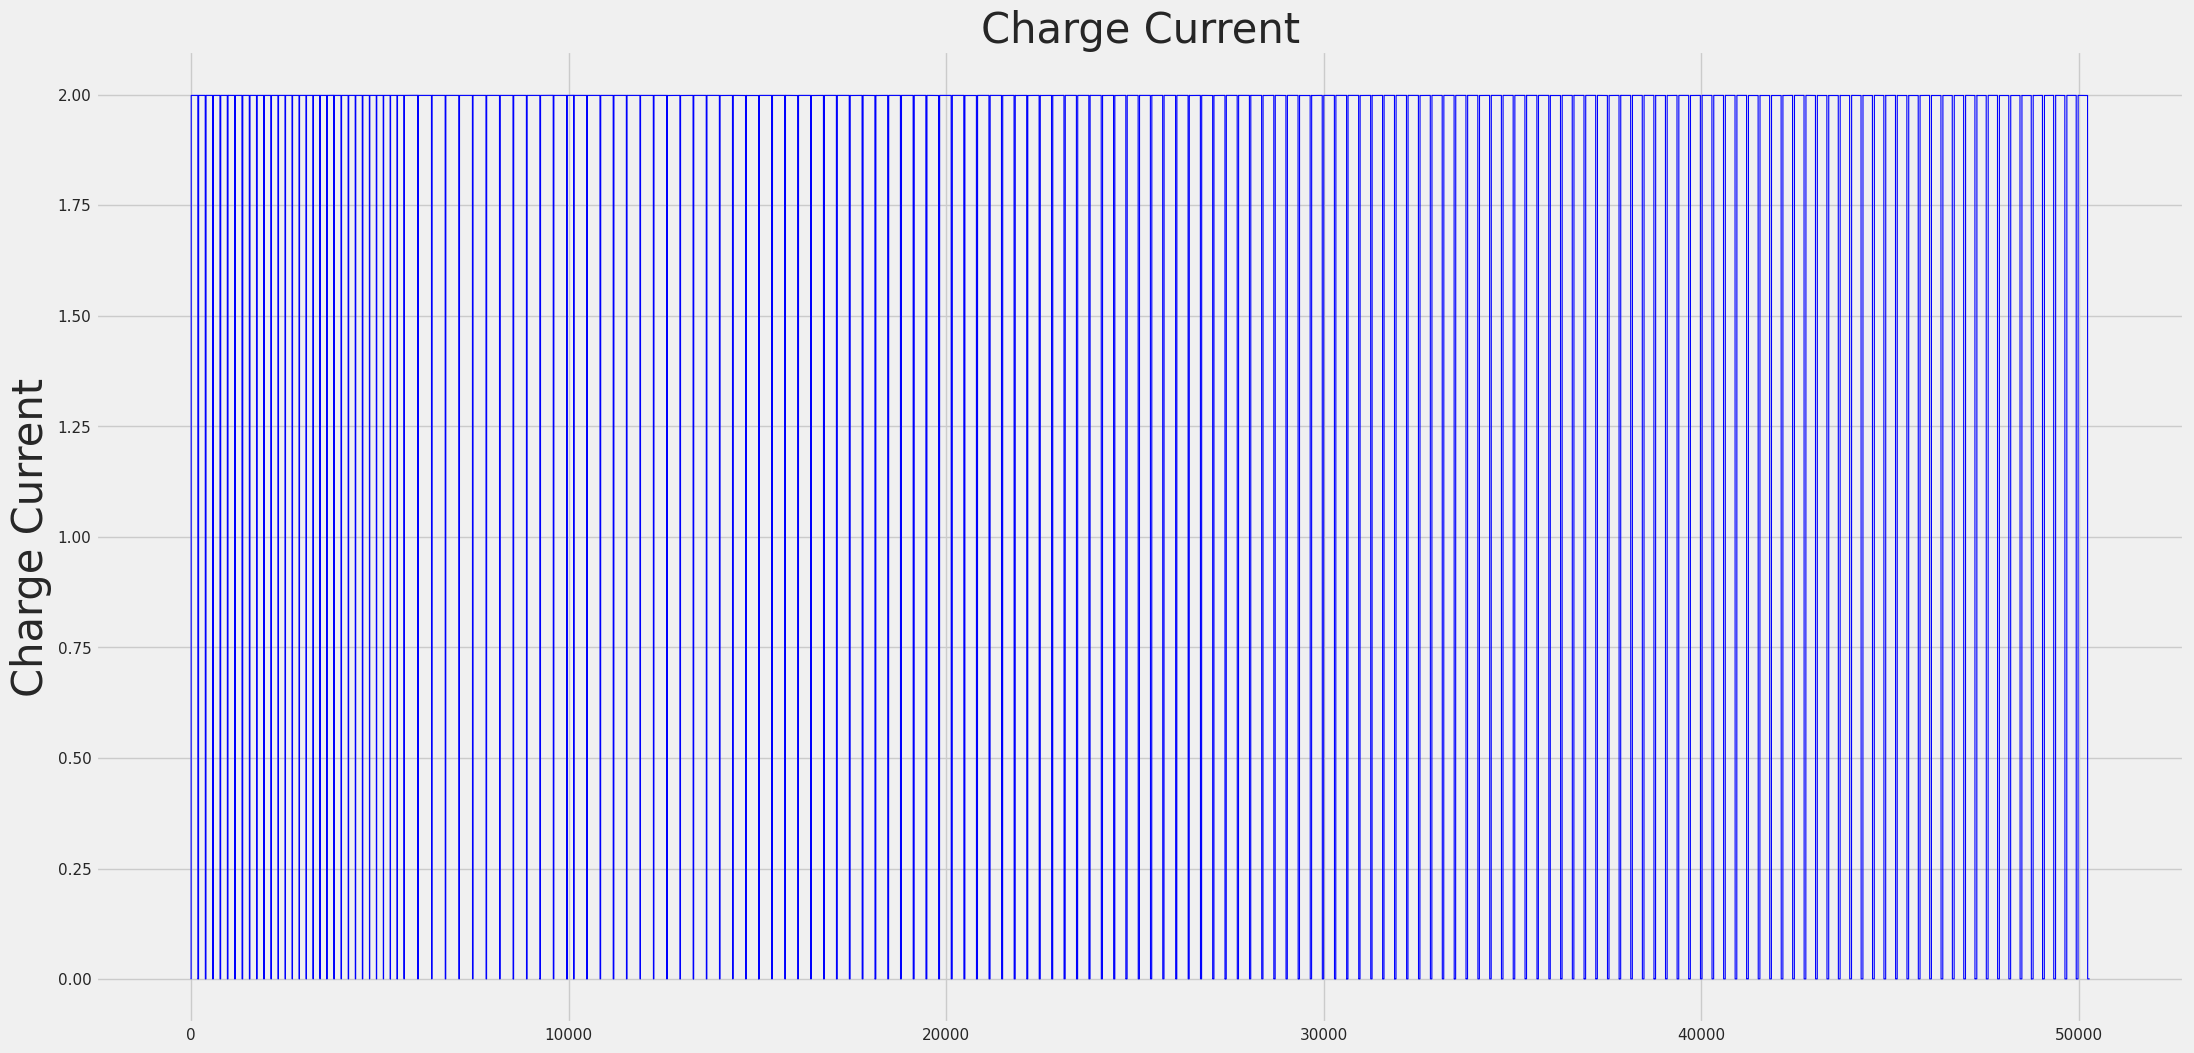

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(24,12))
plt.title("Charge Current",fontsize=30)
sns.set(style="dark")
plt.ylabel('Charge Current', fontsize=30)
plt.plot(battery['charge_current'],color='blue',linewidth=0.8)
plt.show()

In [ ]:
battery['SoH']= None

In [ ]:
battery['Charge']=abs(battery['charge_current'])- abs(battery['terminal_current'])

In [ ]:
battery['Charge'] = pd.to_numeric(battery['Charge'], errors='coerce')

In [ ]:
battery['SoC'] = (2 - abs(battery['Charge'])) / 2

In [ ]:
battery

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,Capacity,Cycle,SoC,SoH,Charge
0,4.191492,-0.004902,24.330034,0.0006,0.000,0.000,1.856487,1,0.997849,None,-0.004302
1,4.190749,-0.001478,24.325993,0.0006,4.206,16.781,1.856487,1,0.999561,None,-0.000878
2,3.974871,-2.012528,24.389085,1.9982,3.062,35.703,1.856487,1,0.992836,None,-0.014328
3,3.951717,-2.013979,24.544752,1.9982,3.030,53.781,1.856487,1,0.992110,None,-0.015779
4,3.934352,-2.011144,24.731385,1.9982,3.011,71.922,1.856487,1,0.993528,None,-0.012944
...,...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312,1.325079,168,0.999515,None,-0.000969
50281,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062,1.325079,168,0.998766,None,-0.002467
50282,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828,1.325079,168,0.998760,None,-0.002479
50283,3.587336,0.001219,34.565580,0.0006,0.000,2810.640,1.325079,168,0.999691,None,-0.000619


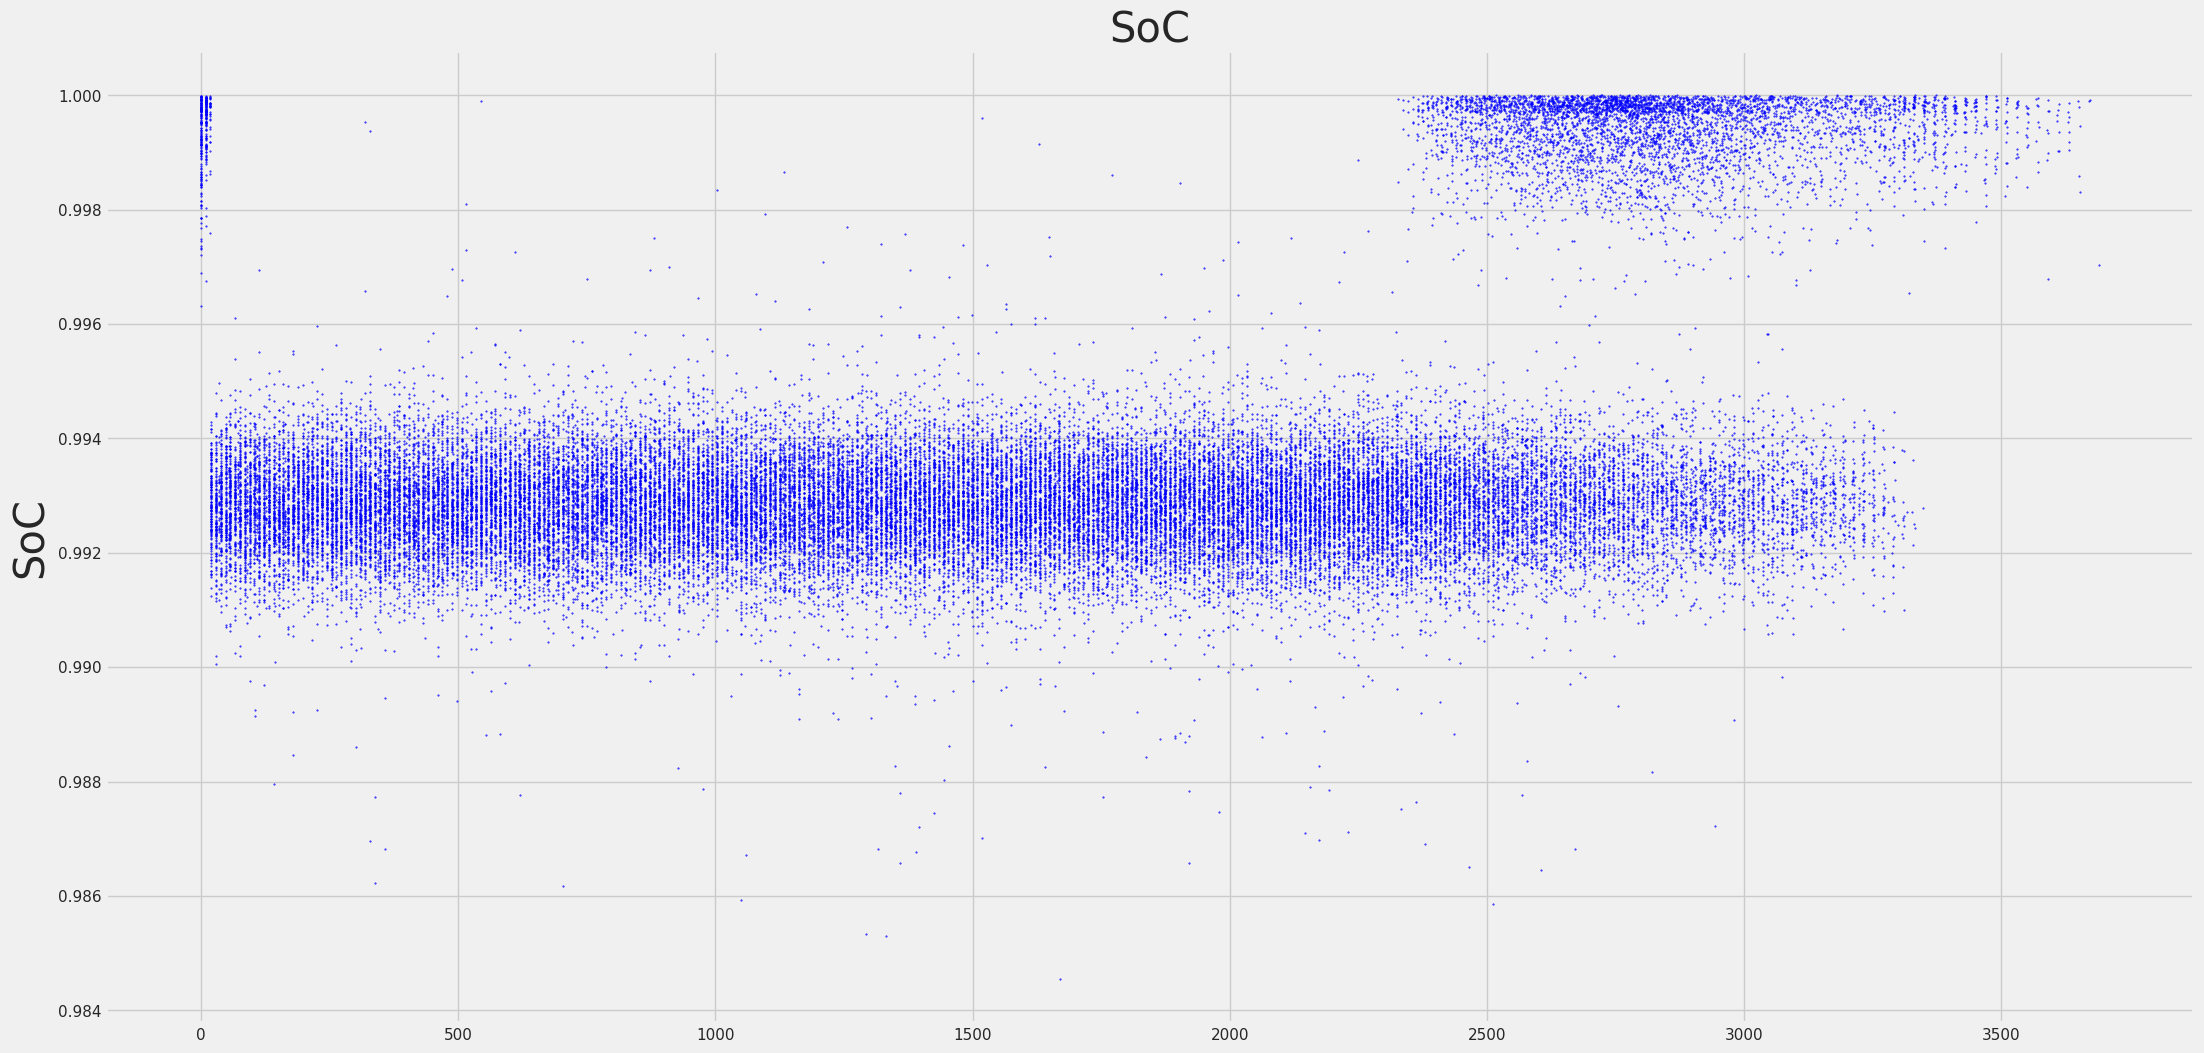

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(24,12))
plt.title("SoC",fontsize=30)
sns.set(style="dark")
plt.ylabel('SoC', fontsize=30)
plt.scatter(battery['time'],battery['SoC'],color='blue',s=0.2)
plt.show()

#3. CALCULATING SoH

In [ ]:
battery['SoH']= None

In [ ]:
T_Current=battery['terminal_current']
C_Current=battery['charge_current']
T_Voltage=battery['terminal_voltage']
C_Voltage=battery['charge_voltage']
cycle=battery['Cycle']
Time=battery['time']
capacity = battery['Capacity']
SOC= battery['SoC']

In [ ]:
SoH = []

In [ ]:
max_cap_full=2

In [ ]:
for i in range(169):
    Temp = []  # Initialize an empty list for each cycle
    for j in range(len(battery)):
        if battery['Cycle'][j] == i:
            Temp.append(battery['Capacity'][j])
    if Temp:  # Check if Temp list is not empty before calculating SoH
        max_cap = max(Temp)

        SoH1 = abs(max_cap / max_cap_full)
        SoH.append(SoH1)

print(SoH)

[0.9282437105, 0.923163625, 0.917674597, 0.917631264, 0.917322754, 0.91783083, 0.9175730715, 0.9128783955, 0.9123869265, 0.912306634, 0.9123097765, 0.907100968, 0.906876079, 0.9067202455, 0.901299002, 0.90105345, 0.9012897505, 0.901534157, 0.9013888125, 0.9235129975, 0.9237086555, 0.9180887105, 0.912890374, 0.912556822, 0.912790752, 0.907015564, 0.907384597, 0.9069846945, 0.9013828325, 0.90203852, 0.925901276, 0.915351923, 0.9099520545, 0.904653982, 0.9023049525, 0.8996885325, 0.894221617, 0.891461524, 0.886516858, 0.8865188775, 0.8839360555, 0.881157535, 0.883808646, 0.88133418, 0.8758652435, 0.8709248025, 0.8680456755, 0.8968120075, 0.891594511, 0.883682104, 0.8785088925, 0.873435309, 0.8708586255, 0.868211253, 0.863160862, 0.8579032695, 0.8552666755, 0.85300725, 0.8501555135, 0.84728993, 0.8424514545, 0.8372370795, 0.837284624, 0.831858188, 0.8295069345, 0.8269270285, 0.821326891, 0.8189289215, 0.8163675205, 0.813876446, 0.811062743, 0.80566283, 0.80328157, 0.8007571115, 0.795184615

In [ ]:
for i in range(169):
    for j in range(50285):
        if battery.loc[j, 'Cycle'] == i+1:
            battery.loc[j, 'SoH'] = SoH[i]

#4. CALCULATING SoF

In [ ]:
battery['SoF']= None
battery['Power_Demand']=None
battery['Instantaneous_Power']=None

In [ ]:
battery['Power_Demand'] = battery['terminal_voltage'] * battery['terminal_current']

In [ ]:
Max_Power=battery['Power_Demand'].max()

In [ ]:
battery['Instantaneous_Power']=(Max_Power*battery['SoC']*battery['SoH'])

In [ ]:
battery['SoF']=((battery['Instantaneous_Power']-abs(battery['Power_Demand']))/abs((Max_Power-battery['Power_Demand'])))

In [ ]:
battery['SoF1']=None

In [ ]:
Sof_limit=0

In [ ]:
battery['SoF1'] = np.where(battery['SoF'] >= Sof_limit, 1, 0)

In [ ]:
battery

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,Capacity,Cycle,SoC,SoH,Charge,SoF,Power_Demand,Instantaneous_Power,SoF1
0,4.191492,-0.004902,24.330034,0.0006,0.000,0.000,1.856487,1,0.997849,0.928244,-0.004302,0.055743,-0.020545,0.023079,1
1,4.190749,-0.001478,24.325993,0.0006,4.206,16.781,1.856487,1,0.999561,0.928244,-0.000878,0.544016,-0.006194,0.023119,1
2,3.974871,-2.012528,24.389085,1.9982,3.062,35.703,1.856487,1,0.992836,0.928244,-0.014328,-0.994033,-7.999540,0.022963,0
3,3.951717,-2.013979,24.544752,1.9982,3.030,53.781,1.856487,1,0.992110,0.928244,-0.015779,-0.994005,-7.958676,0.022946,0
4,3.934352,-2.011144,24.731385,1.9982,3.011,71.922,1.856487,1,0.993528,0.928244,-0.012944,-0.993966,-7.912548,0.022979,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312,1.325079,168,0.999515,0.66254,-0.000969,0.356414,-0.005618,0.0165,1
50281,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062,1.325079,168,0.998766,0.66254,-0.002467,0.153238,-0.010986,0.016488,1
50282,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828,1.325079,168,0.998760,0.66254,-0.002479,0.151608,-0.011037,0.016488,1
50283,3.587336,0.001219,34.565580,0.0006,0.000,2810.640,1.325079,168,0.999691,0.66254,-0.000619,0.590489,0.004371,0.016503,1


#5. ANALYZING DATA

In [ ]:
Cyc0 = []  # Initialize a list to store individual cycle values

for i in range(50285):  # Loop through the specified range
    Cyc0.append([battery['Cycle'][i]])  # Append a list with the 'cycle' value at index i to Cyc1

Cyc0_array = np.array(Cyc0)  # Convert the list of lists to a NumPy array

print(Cyc0_array)

[[  1]
 [  1]
 [  1]
 ...
 [168]
 [168]
 [168]]


In [ ]:
Cyc01 = Cyc0_array.flatten()

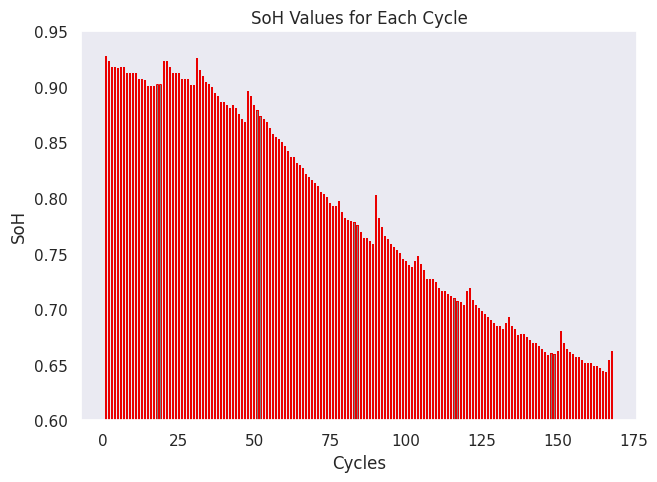

In [ ]:
plt.bar(Cyc01,battery['SoH'], width=.02,color='grey',edgecolor ='red',linewidth=.02)  # Adjust the width as needed
plt.ylim(0.6,0.95)
plt.xlabel('Cycles')
plt.ylabel('SoH')
plt.title('SoH Values for Each Cycle')
plt.show()

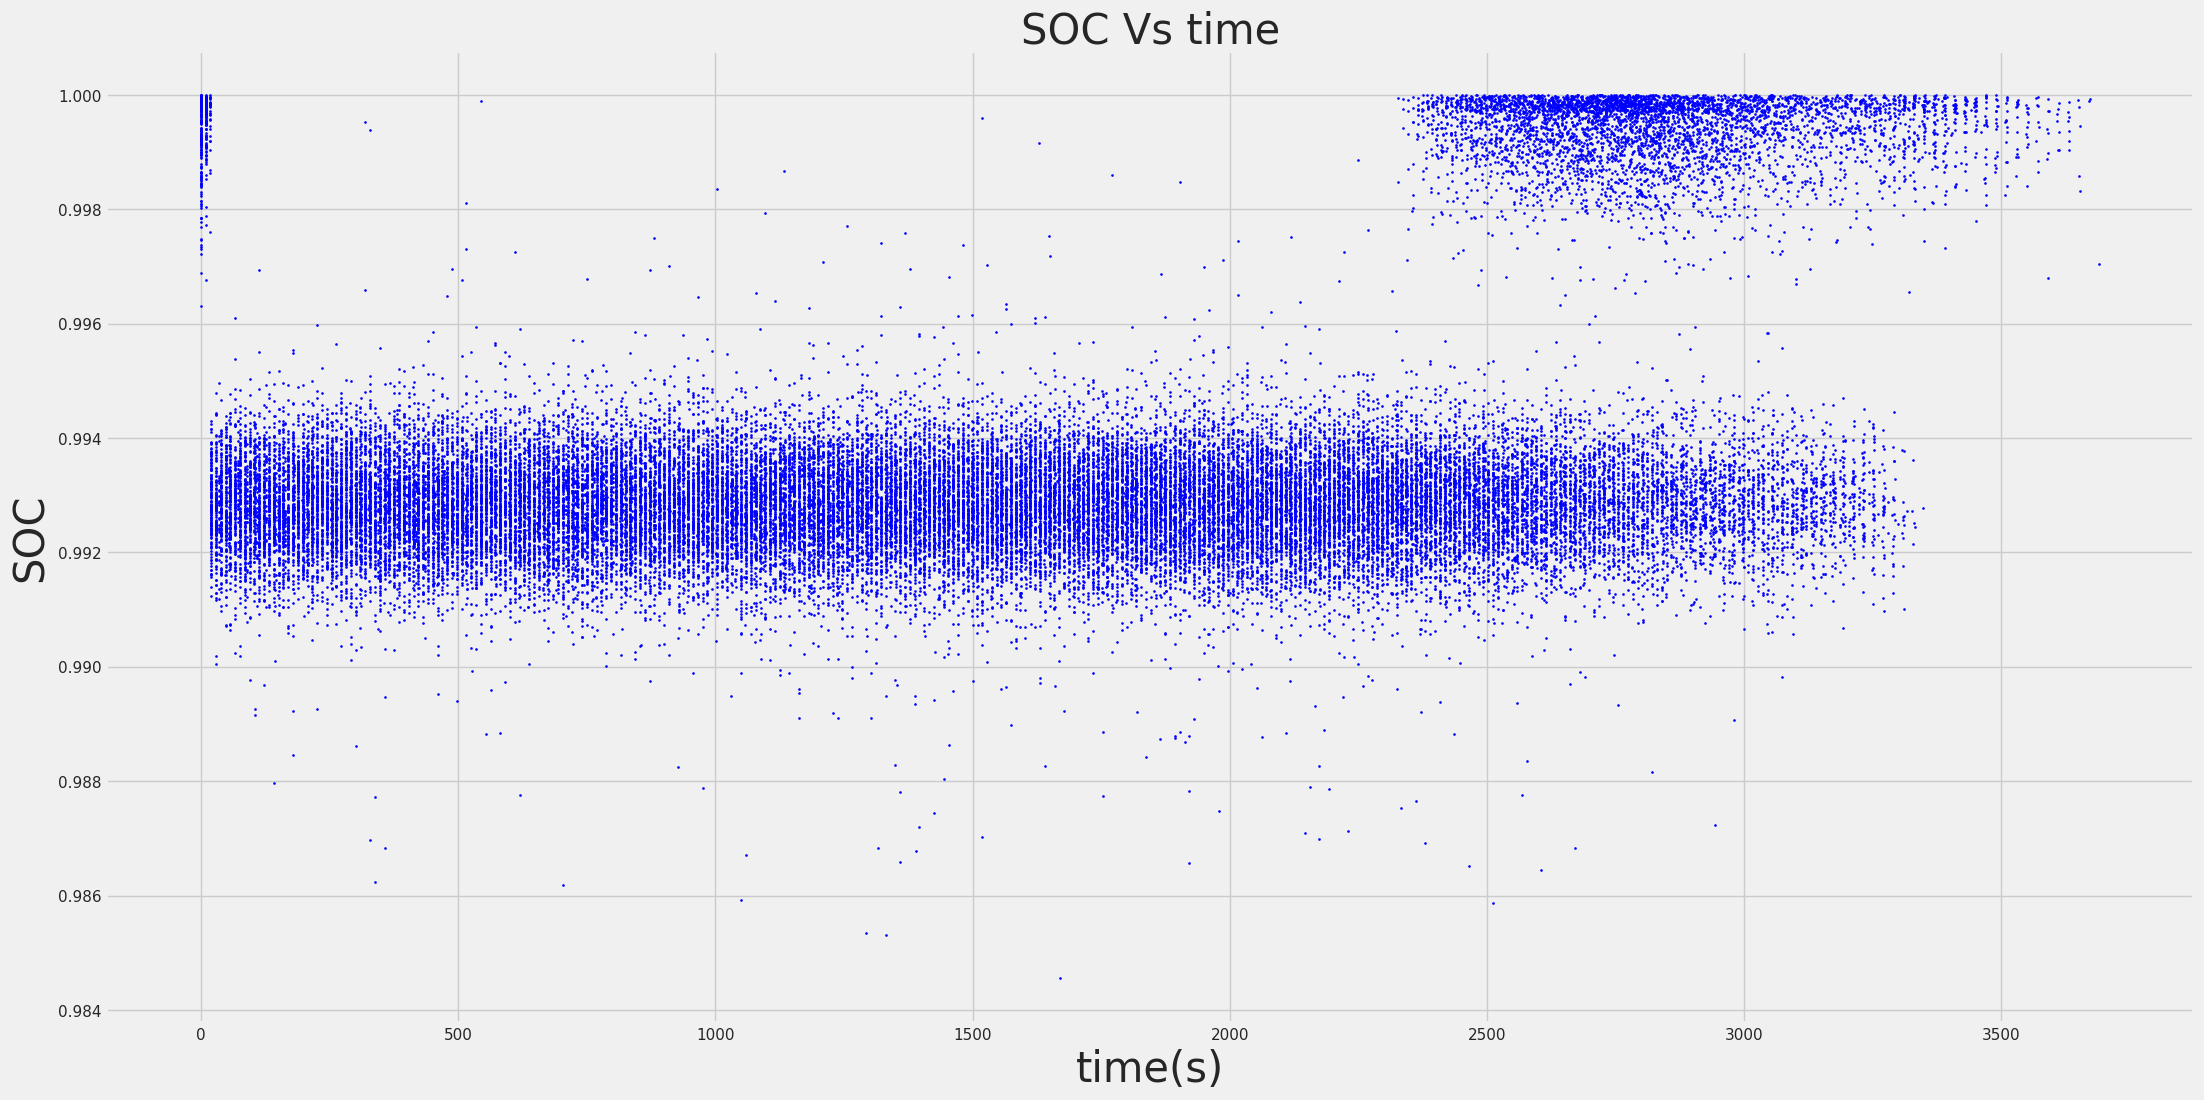

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(24,12))
plt.title("SOC Vs time",fontsize=30)
sns.set(style="dark")
plt.xlabel('time(s)', fontsize=30)
plt.ylabel('SOC', fontsize=30)
plt.scatter(battery['time'],SOC,color='blue',s=0.8)
plt.show()

#6. CREATING INPUT FOR LSTM MODEL

In [ ]:
X0=[]
X1=[]
X2=[]
X3=[]
X4=[]
X5=[]
X6=[]
X7=[]
X8=[]
X9=[]
y1=[]
y2=[]

In [ ]:
for i in range(0,battery.shape[0]-60):
  X0.append(battery.iloc[i:i + 60, 0])
  X1.append(battery.iloc[i:i + 60, 1])
  X2.append(battery.iloc[i:i + 60, 2])
  X3.append(battery.iloc[i:i + 60, 3])
  X4.append(battery.iloc[i:i + 60, 4])
  X5.append(battery.iloc[i:i + 60, 5])
  X6.append(battery.iloc[i:i + 60, 6])
  X7.append(battery.iloc[i:i + 60, 7])
  X8.append(battery.iloc[i:i + 60, 8])
  X9.append(battery.iloc[i:i + 60, 9])
  y1.append(battery.iloc[i + 60, 8])
  y2.append(battery.iloc[i + 60, 9])

In [ ]:
X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,y1,y2= np.array(X0),np.array(X1),np.array(X2),np.array(X3),np.array(X4),np.array(X5),np.array(X6),np.array(X7),np.array(X8),np.array(X9),np.array(y1),np.array(y2)

In [ ]:
y1=np.reshape(y1,(len(y1),1))
y1.shape

(50225, 1)

In [ ]:
y2=np.reshape(y2,(len(y2),1))
y2.shape

(50225, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scalar= MinMaxScaler(feature_range=(0,1))
X0=scalar.fit_transform(X0)
X1=scalar.fit_transform(X1)
X2=scalar.fit_transform(X2)
X3=scalar.fit_transform(X3)
X4=scalar.fit_transform(X4)
X5=scalar.fit_transform(X5)
X6=scalar.fit_transform(X6)
X7=scalar.fit_transform(X7)
X8=scalar.fit_transform(X8)
X9=scalar.fit_transform(X9)
y1=scalar.fit_transform(y1)
y2=scalar.fit_transform(y2)

In [ ]:
X=np.stack([X0,X1,X2,X3,X4,X5,X6,X7,X8,X9],axis=2)

In [ ]:
print("SHAPE OF INPUT TO LSTM : ",X.shape)

SHAPE OF INPUT TO LSTM :  (50225, 60, 10)


In [ ]:
X_train, X_test=X[:-10259],X[-10259:]
y1_train, y1_test=y1[:-10259],y1[-10259:]

In [ ]:
X_train, X_test=X[:-10259],X[-10259:]
y2_train, y2_test=y2[:-10259],y2[-10259:]

In [ ]:
X_train.shape[1],X_train.shape[2]

(60, 10)

#7. TESTING LSTM MODEL

In [ ]:
model1=Sequential()
model1.add(LSTM(250,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model1.add(Dropout(0.2))
model1.add(LSTM(250,return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(8,activation='relu'))
model1.add(Dense(1))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 250)           261000    
                                                                 
 dropout (Dropout)           (None, 60, 250)           0         
                                                                 
 lstm_1 (LSTM)               (None, 250)               501000    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense (Dense)               (None, 8)                 2008      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 764017 (2.91 MB)
Trainable params: 764017 

In [ ]:
model2=Sequential()
model2.add(LSTM(220,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(220,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(220,return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(8,activation='relu'))
model2.add(Dense(1))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 220)           203280    
                                                                 
 dropout_2 (Dropout)         (None, 60, 220)           0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 220)           388080    
                                                                 
 dropout_3 (Dropout)         (None, 60, 220)           0         
                                                                 
 lstm_4 (LSTM)               (None, 220)               388080    
                                                                 
 dropout_4 (Dropout)         (None, 220)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                

In [ ]:
filepath1= '/content/drive/MyDrive/B005_SOC_CALLBACK/{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{mae:.4f}-{val_mae:.4f}.hdf5'

In [ ]:
filepath2= '/content/drive/MyDrive/B005_SOH_CALLBACK/{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{mae:.4f}-{val_mae:.4f}.hdf5'

In [ ]:
callbacks1 = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath1, monitor='loss', save_best_only=True, mode='min')]

In [ ]:
callbacks2 = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath2, monitor='loss', save_best_only=True, mode='min')]

In [ ]:
optimizers.SGD(momentum=0.9)
model1.compile(optimizer='SGD',loss='mse',metrics=['accuracy','mae'])

In [ ]:
optimizers.SGD(momentum=0.9)
model2.compile(optimizer='SGD',loss='mse',metrics=['accuracy','mae'])

In [ ]:
model1.fit(X_train,y1_train,validation_split=0.2,epochs=1,callbacks=callbacks1 , batch_size=16)

1999/1999 [==============================] - 539s 267ms/step - loss: 0.0098 - accuracy: 0.0000e+00 - mae: 0.0685 - val_loss: 0.0063 - val_accuracy: 1.2509e-04 - val_mae: 0.0563


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model2.fit(X_train,y2_train,validation_split=0.2,epochs=1 ,callbacks=callbacks2 , batch_size=16)

1999/1999 [==============================] - 782s 388ms/step - loss: 0.0039 - accuracy: 0.0043 - mae: 0.0396 - val_loss: 2.5026e-04 - val_accuracy: 0.0000e+00 - val_mae: 0.0121


#8. ANALYZING RESULTS OF SoC & SoH

In [ ]:
MSE_SOC,ACC_SOC,MAE_SOC=model1.evaluate(X_test,y1_test)
print("MEAN SQUARE ERROR : ",MSE_SOC)
print("ACCURACY : ",ACC_SOC)
print("MEAN ABSOLUT ERROR : ",MAE_SOC)

321/321 [==============================] - 38s 117ms/step - loss: 0.0058 - accuracy: 0.0000e+00 - mae: 0.0548
MEAN SQUARE ERROR :  0.005819824989885092
ACCURACY :  0.0
MEAN ABSOLUT ERROR :  0.054820142686367035


In [ ]:
MSE__SOH,ACC__SOH,MAE__SOH=model2.evaluate(X_test,y2_test)
print("MEAN SQUARE ERROR : ",MSE__SOH)
print("ACCURACY : ",ACC__SOH)
print("MEAN ABSOLUT ERROR : ",MAE__SOH)

321/321 [==============================] - 52s 163ms/step - loss: 0.0049 - accuracy: 0.0290 - mae: 0.0660
MEAN SQUARE ERROR :  0.004879304673522711
ACCURACY :  0.028950190171599388
MEAN ABSOLUT ERROR :  0.06600883603096008


In [ ]:
predictions_SoC=model1.predict(X_test)
predictions_SoC=scalar.inverse_transform(predictions_SoC)
print("THE PREDICTED VALUES OF SoC FOR TEST SET IS : \n",predictions_SoC)

321/321 [==============================] - 48s 145ms/step
THE PREDICTED VALUES OF SoC FOR TEST SET IS : 
 [[0.8928513]
 [0.8863445]
 [0.8738739]
 ...
 [0.8974849]
 [0.897094 ]
 [0.8967952]]


In [ ]:
predictions_SoH=model2.predict(X_test)
predictions_SoH=scalar.inverse_transform(predictions_SoH)
print("THE PREDICTED VALUES OF SoH FOR TEST SET IS : \n",predictions_SoH)

321/321 [==============================] - 56s 170ms/step
THE PREDICTED VALUES OF SoH FOR TEST SET IS : 
 [[0.69914025]
 [0.69901365]
 [0.6987265 ]
 ...
 [0.68088734]
 [0.6809569 ]
 [0.68102807]]


In [ ]:
Cyc1 = []
for i in range(40026, 50285):
    Cyc1.append([battery['Cycle'][i]])

Cyc1_array = np.array(Cyc1)

print(Cyc1_array)

[[135]
 [135]
 [135]
 ...
 [168]
 [168]
 [168]]


In [ ]:
Time1 = []  # Initialize a list to store individual cycle values

for i in range(40026, 50285):  # Loop through the specified range
    Time1.append([battery['time'][i]])  # Append a list with the 'cycle' value at index i to Cyc1

Time1_array = np.array(Time1)  # Convert the list of lists to a NumPy array

print(Time1_array)

[[   9.469]
 [  19.641]
 [  29.   ]
 ...
 [2800.828]
 [2810.64 ]
 [2820.39 ]]


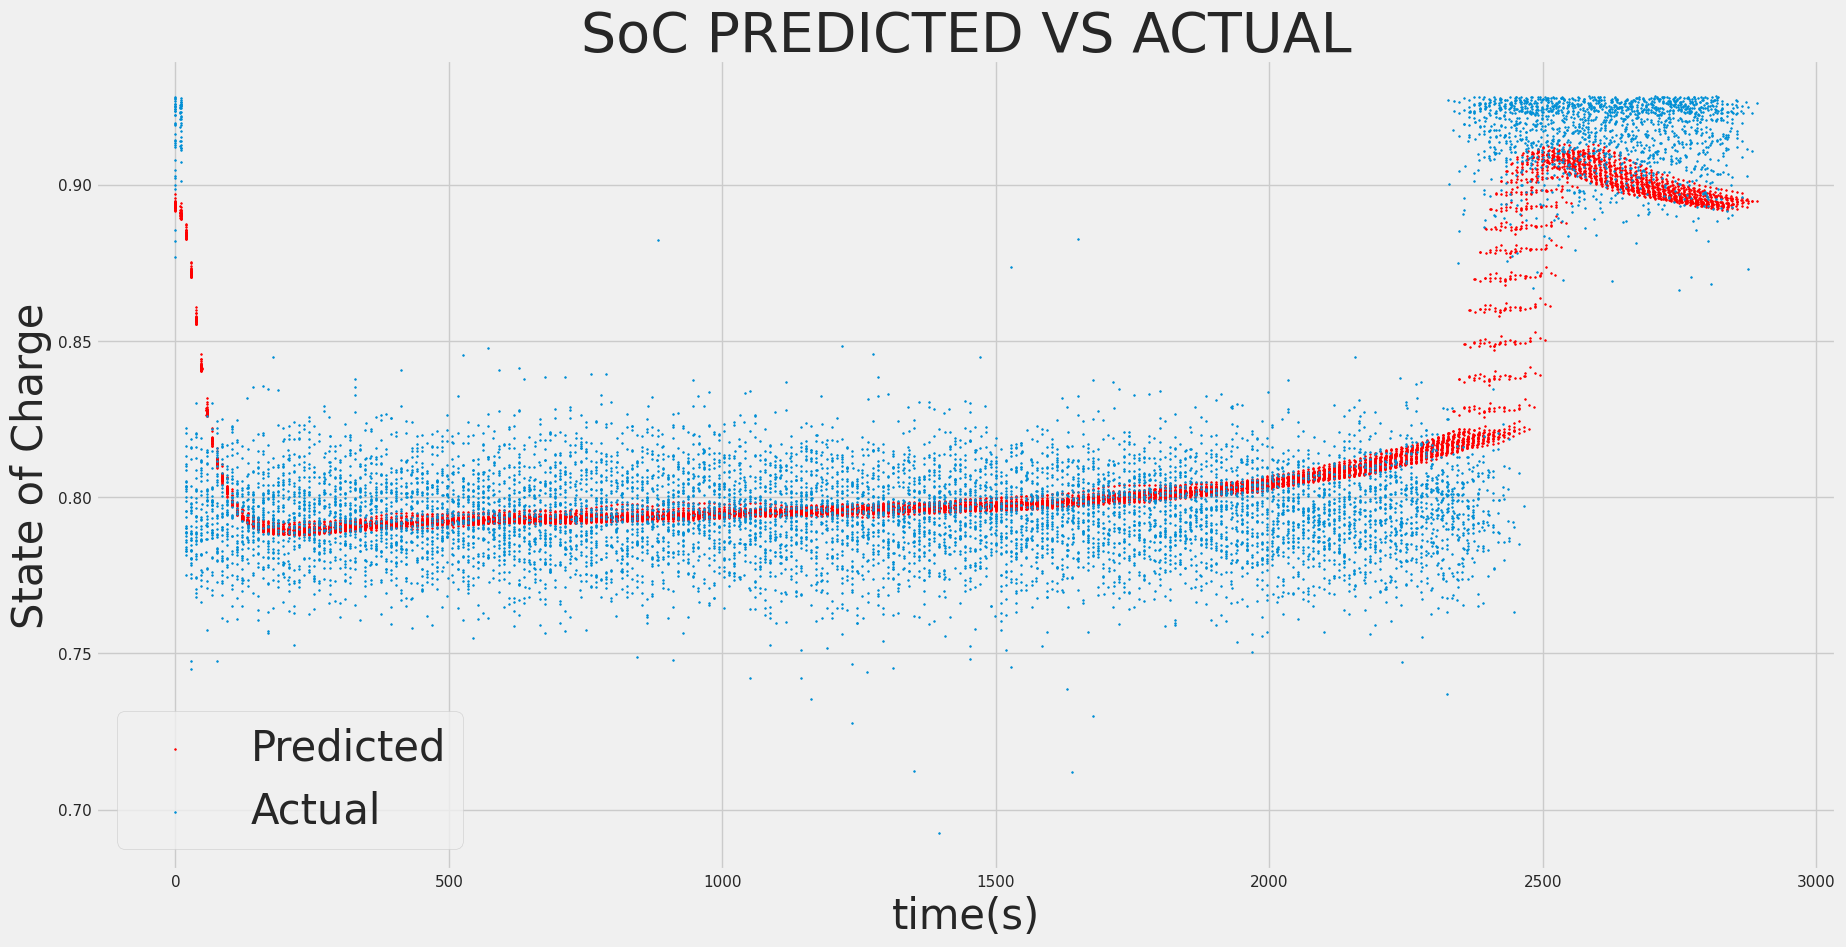

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.title('SoC PREDICTED VS ACTUAL',fontsize=40)
plt.xlabel('time(s)',fontsize=30)
plt.ylabel('State of Charge',fontsize=30)
#plt.xticks(np.arange(0, 10000, 334))
plt.scatter(Time1_array,predictions_SoC,color='red',s=1.5)
plt.scatter(Time1_array,scalar.inverse_transform(y1_test), s=1.5)
plt.legend(['Predicted','Actual'],fontsize=30)
plt.show()

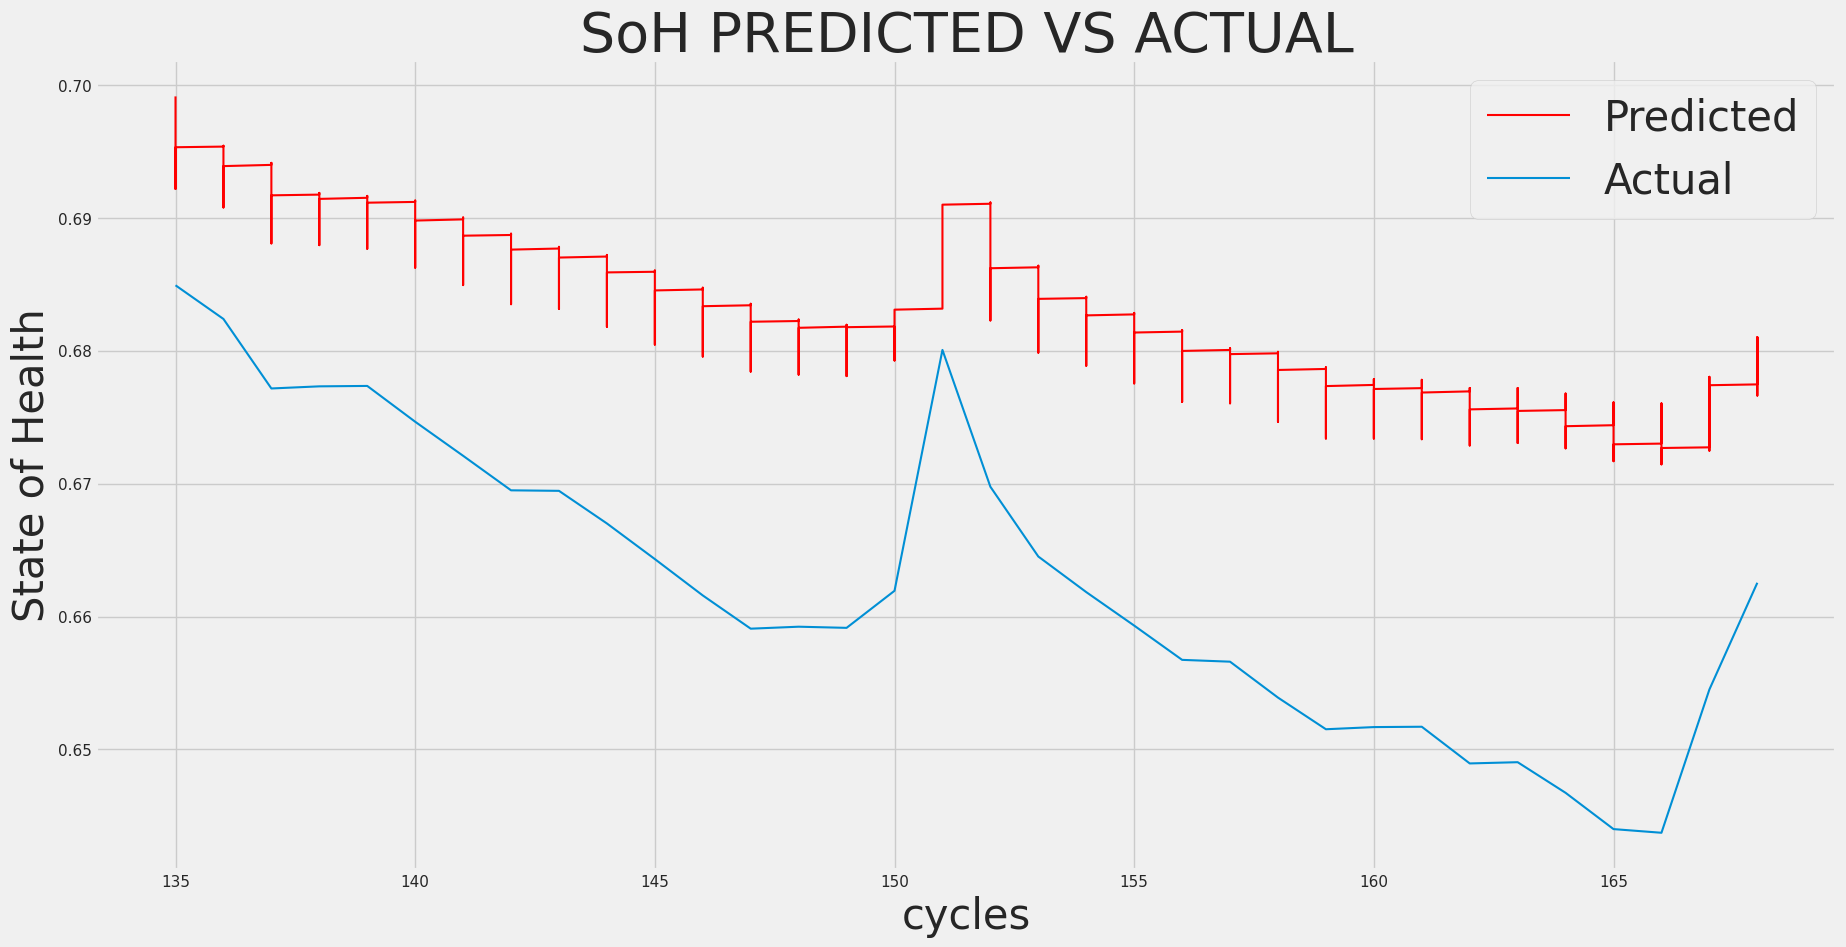

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.title('SoH PREDICTED VS ACTUAL',fontsize=40)
plt.xlabel('cycles',fontsize=30)
plt.ylabel('State of Health',fontsize=30)
#plt.xticks(np.arange(0, 10000, 334))
plt.plot(Cyc1_array,predictions_SoH,color='red',linewidth=1.5)
plt.plot(Cyc1,scalar.inverse_transform(y2_test), linewidth=1.5)
plt.legend(['Predicted','Actual'],fontsize=30)
plt.show()

In [ ]:
Cyc2 = Cyc1_array.flatten()

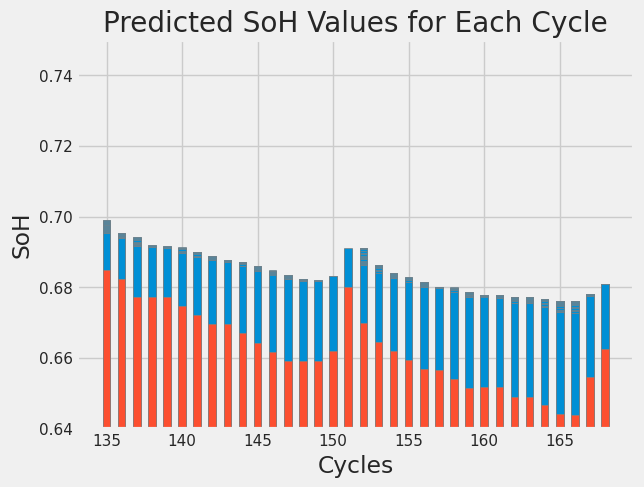

In [ ]:
plt.bar(Cyc2, predictions_SoH.flatten(), width=.5,edgecolor ='grey')  # Adjust the width as needed
plt.bar(Cyc2, scalar.inverse_transform(y2_test).flatten(), width=.5,edgecolor ='grey')
plt.ylim(0.64,0.75)
plt.xlabel('Cycles')
plt.ylabel('SoH')
plt.title('Predicted SoH Values for Each Cycle')
plt.show()

#9. CALCULATING SoF FROM PREDICTED SoC & SoH

In [ ]:
Battery_pred=battery[-10259:]

In [ ]:
Battery_pred['SoF']= None
Battery_pred['Power_Demand']=None
Battery_pred['Instantaneous_Power']=None

<ipython-input-66-9bbe69f448e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Battery_pred['SoF']= None
<ipython-input-66-9bbe69f448e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Battery_pred['Power_Demand']=None
<ipython-input-66-9bbe69f448e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [ ]:
Battery_pred

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,Capacity,Cycle,SoC,SoH,Charge,SoF,Power_Demand,Instantaneous_Power,SoF1
40026,4.197523,0.001294,24.576581,0.0006,4.213,9.469,1.369850,135,0.999653,0.684925,-0.000694,None,None,None,1
40027,3.982348,-2.010698,24.604090,1.9982,2.968,19.641,1.369850,135,0.993751,0.684925,-0.012498,None,None,None,0
40028,3.960702,-2.010417,24.675925,1.9982,2.963,29.000,1.369850,135,0.993891,0.684925,-0.012217,None,None,None,0
40029,3.943893,-2.015319,24.771451,1.9982,2.953,38.375,1.369850,135,0.991441,0.684925,-0.017119,None,None,None,0
40030,3.929406,-2.012673,24.880584,1.9980,2.941,47.719,1.369850,135,0.992664,0.684925,-0.014673,None,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312,1.325079,168,0.999515,0.66254,-0.000969,None,None,None,1
50281,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062,1.325079,168,0.998766,0.66254,-0.002467,None,None,None,1
50282,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828,1.325079,168,0.998760,0.66254,-0.002479,None,None,None,1
50283,3.587336,0.001219,34.565580,0.0006,0.000,2810.640,1.325079,168,0.999691,0.66254,-0.000619,None,None,None,1


In [ ]:
Battery_pred['Power_Demand'] = Battery_pred['terminal_voltage'] * Battery_pred['terminal_current']

<ipython-input-68-ae0a6163fcc2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Battery_pred['Power_Demand'] = Battery_pred['terminal_voltage'] * Battery_pred['terminal_current']


In [ ]:
#Max_Power=Battery_pred['Power_Demand'].max()

In [ ]:
drop_columns=['temperature','charge_current','charge_voltage','Capacity','SoC','SoH']

In [ ]:
Battery_pred=Battery_pred.drop(columns=drop_columns)

In [ ]:
Battery_pred

,terminal_voltage,terminal_current,time,Cycle,Charge,SoF,Power_Demand,Instantaneous_Power,SoF1
40026,4.197523,0.001294,9.469,135,-0.000694,None,0.005431,None,1
40027,3.982348,-2.010698,19.641,135,-0.012498,None,-8.007301,None,0
40028,3.960702,-2.010417,29.000,135,-0.012217,None,-7.962663,None,0
40029,3.943893,-2.015319,38.375,135,-0.017119,None,-7.948202,None,0
40030,3.929406,-2.012673,47.719,135,-0.014673,None,-7.908609,None,0
...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,2781.312,168,-0.000969,None,-0.005618,None,1
50281,3.581964,-0.003067,2791.062,168,-0.002467,None,-0.010986,None,1
50282,3.584484,-0.003079,2800.828,168,-0.002479,None,-0.011037,None,1
50283,3.587336,0.001219,2810.640,168,-0.000619,None,0.004371,None,1


In [ ]:
pred_SoC=np.array(predictions_SoC)
pred_SoH=np.array(predictions_SoH)

In [ ]:
pred_SoC=pred_SoC.flatten()
pred_SoH=pred_SoH.flatten()

In [ ]:
SoC_df = pd.DataFrame({'SoC': pred_SoC},index=Battery_pred.index)
SoH_df = pd.DataFrame({'SoH': pred_SoH},index=Battery_pred.index)

In [ ]:
Battery_pred = pd.concat([Battery_pred, SoC_df], axis=1)
Battery_pred = pd.concat([Battery_pred, SoH_df], axis=1)

In [ ]:
Battery_pred

,terminal_voltage,terminal_current,time,Cycle,Charge,SoF,Power_Demand,Instantaneous_Power,SoF1,SoC,SoH
40026,4.197523,0.001294,9.469,135,-0.000694,None,0.005431,None,1,0.892851,0.699140
40027,3.982348,-2.010698,19.641,135,-0.012498,None,-8.007301,None,0,0.886344,0.699014
40028,3.960702,-2.010417,29.000,135,-0.012217,None,-7.962663,None,0,0.873874,0.698726
40029,3.943893,-2.015319,38.375,135,-0.017119,None,-7.948202,None,0,0.858929,0.698314
40030,3.929406,-2.012673,47.719,135,-0.014673,None,-7.908609,None,0,0.843414,0.698088
...,...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,2781.312,168,-0.000969,None,-0.005618,None,1,0.898103,0.680779
50281,3.581964,-0.003067,2791.062,168,-0.002467,None,-0.010986,None,1,0.897835,0.680829
50282,3.584484,-0.003079,2800.828,168,-0.002479,None,-0.011037,None,1,0.897485,0.680887
50283,3.587336,0.001219,2810.640,168,-0.000619,None,0.004371,None,1,0.897094,0.680957


In [ ]:
Battery_pred['Instantaneous_Power']=(Max_Power*Battery_pred['SoC']*Battery_pred['SoH'])

In [ ]:
Battery_pred['SoF']=((Battery_pred['Instantaneous_Power']-abs(Battery_pred['Power_Demand']))/(Max_Power-abs(Battery_pred['Power_Demand'])))

In [ ]:
Battery_pred

,terminal_voltage,terminal_current,time,Cycle,Charge,SoF,Power_Demand,Instantaneous_Power,SoF1,SoC,SoH
40026,4.197523,0.001294,9.469,135,-0.000694,0.519495,0.005431,0.015554,1,0.892851,0.699140
40027,3.982348,-2.010698,19.641,135,-0.012498,1.001188,-8.007301,0.015438,0,0.886344,0.699014
40028,3.960702,-2.010417,29.000,135,-0.012217,1.001222,-7.962663,0.015214,0,0.873874,0.698726
40029,3.943893,-2.015319,38.375,135,-0.017119,1.001259,-7.948202,0.014945,0,0.858929,0.698314
40030,3.929406,-2.012673,47.719,135,-0.014673,1.001300,-7.908609,0.014670,0,0.843414,0.698088
...,...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,2781.312,168,-0.000969,0.498302,-0.005618,0.015234,1,0.898103,0.680779
50281,3.581964,-0.003067,2791.062,168,-0.002467,0.304702,-0.010986,0.015231,1,0.897835,0.680829
50282,3.584484,-0.003079,2800.828,168,-0.002479,0.301826,-0.011037,0.015226,1,0.897485,0.680887
50283,3.587336,0.001219,2810.640,168,-0.000619,0.528089,0.004371,0.015221,1,0.897094,0.680957


In [ ]:
Battery_pred['SoF1']=None

In [ ]:
Sof_limit=0

In [ ]:
Battery_pred['SoF1'] = np.where(Battery_pred['SoF'] >= Sof_limit, 1, 0)

In [ ]:
Battery_pred

,terminal_voltage,terminal_current,time,Cycle,Charge,SoF,Power_Demand,Instantaneous_Power,SoF1,SoC,SoH
40026,4.197523,0.001294,9.469,135,-0.000694,0.519495,0.005431,0.015554,1,0.892851,0.699140
40027,3.982348,-2.010698,19.641,135,-0.012498,1.001188,-8.007301,0.015438,1,0.886344,0.699014
40028,3.960702,-2.010417,29.000,135,-0.012217,1.001222,-7.962663,0.015214,1,0.873874,0.698726
40029,3.943893,-2.015319,38.375,135,-0.017119,1.001259,-7.948202,0.014945,1,0.858929,0.698314
40030,3.929406,-2.012673,47.719,135,-0.014673,1.001300,-7.908609,0.014670,1,0.843414,0.698088
...,...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,2781.312,168,-0.000969,0.498302,-0.005618,0.015234,1,0.898103,0.680779
50281,3.581964,-0.003067,2791.062,168,-0.002467,0.304702,-0.010986,0.015231,1,0.897835,0.680829
50282,3.584484,-0.003079,2800.828,168,-0.002479,0.301826,-0.011037,0.015226,1,0.897485,0.680887
50283,3.587336,0.001219,2810.640,168,-0.000619,0.528089,0.004371,0.015221,1,0.897094,0.680957


#10. PLOTTING RESULTS OF SoF

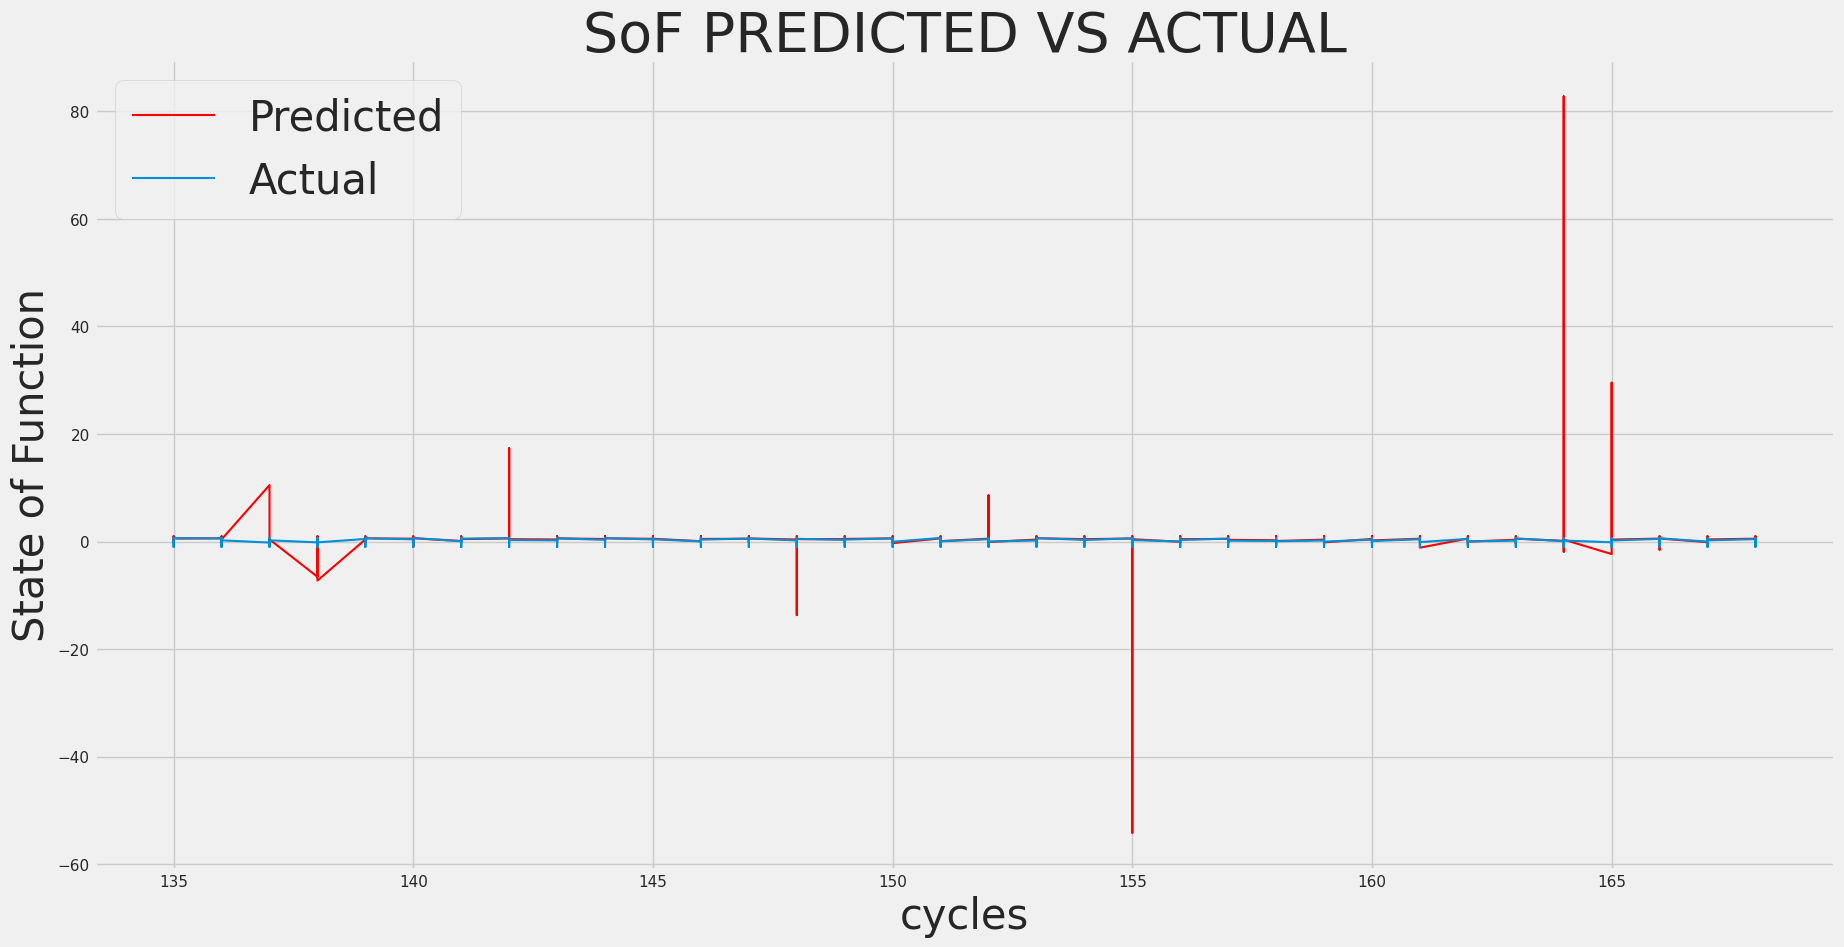

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.title('SoF PREDICTED VS ACTUAL',fontsize=40)
plt.xlabel('cycles',fontsize=30)
plt.ylabel('State of Function',fontsize=30)
#plt.xticks(np.arange(0, 10000, 334))
plt.plot(Cyc1_array,Battery_pred['SoF'],color='red',linewidth=1.5)
plt.plot(Cyc1_array,battery['SoF'][-10259:], linewidth=1.5)
plt.legend(['Predicted','Actual'],fontsize=30)
plt.show()

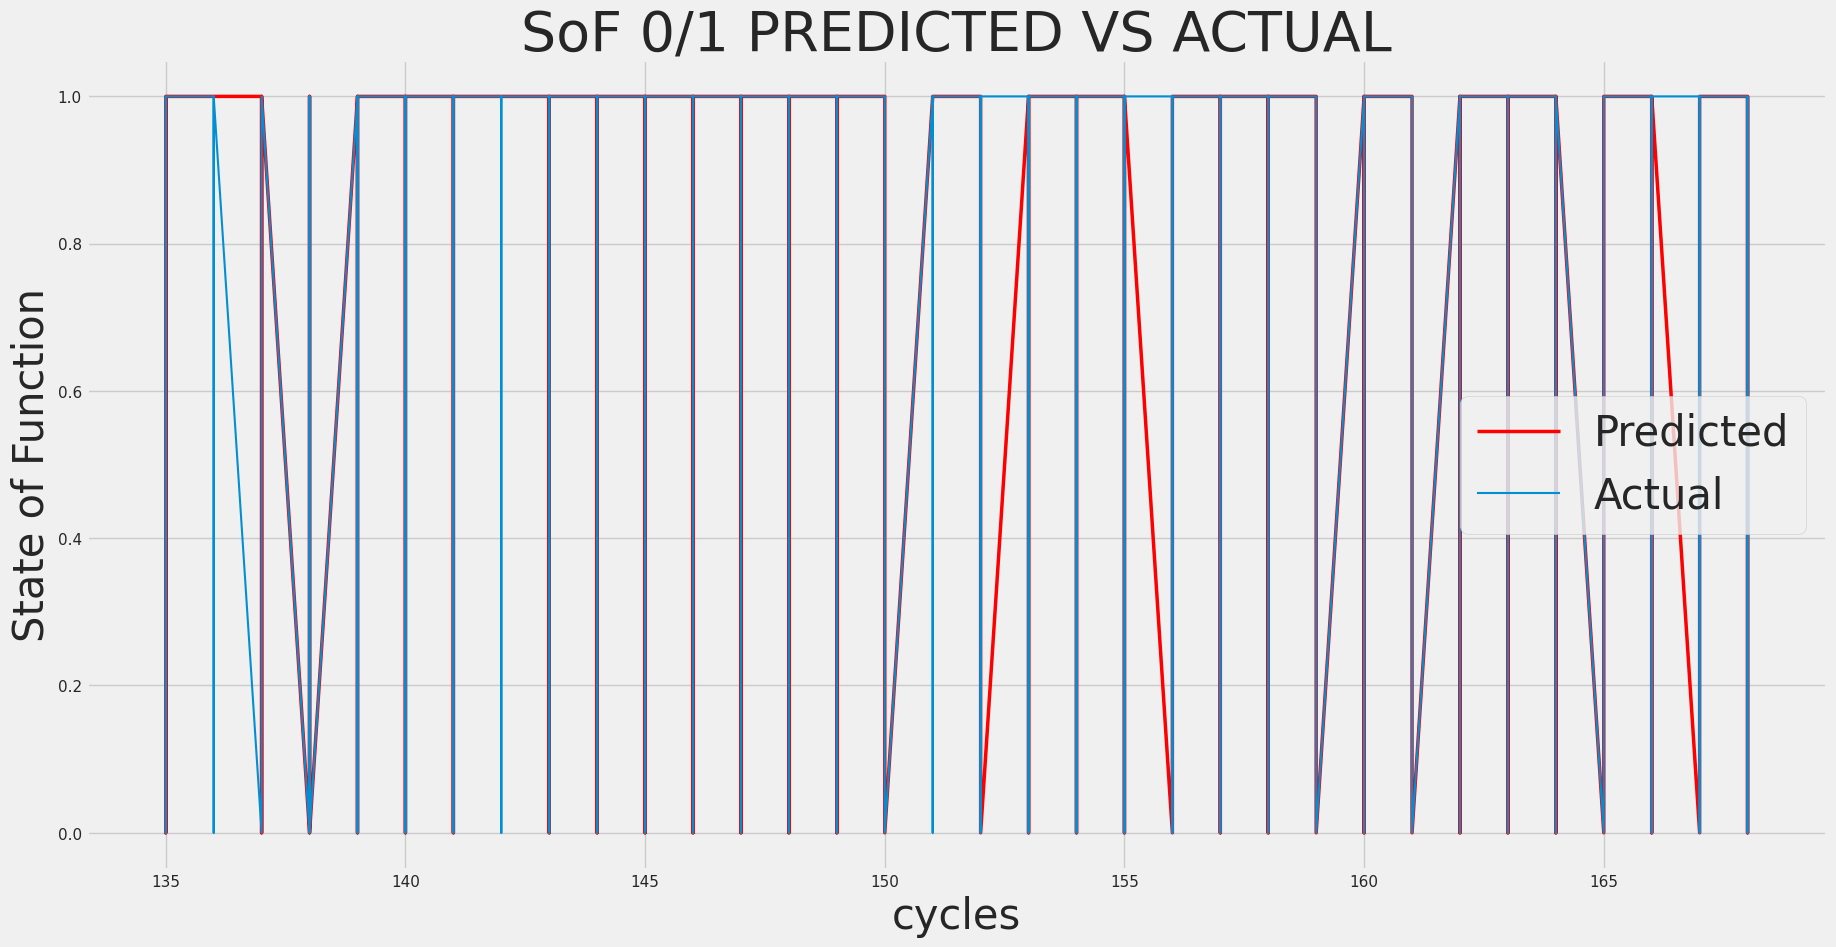

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.title('SoF 0/1 PREDICTED VS ACTUAL',fontsize=40)
plt.xlabel('cycles',fontsize=30)
plt.ylabel('State of Function',fontsize=30)
#plt.xticks(np.arange(0, 10000, 334))
plt.plot(Cyc1_array,Battery_pred['SoF1'],color='red',linewidth=2.5)
plt.plot(Cyc1_array,battery['SoF1'][-10259:], linewidth=1.5)
plt.legend(['Predicted','Actual'],fontsize=30)
plt.show()

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.title('SoF 0/1 PREDICTED VS ACTUAL',fontsize=40)
plt.xlabel('cycles',fontsize=30)
plt.ylabel('State of Function',fontsize=30)
#plt.xticks(np.arange(0, 10000, 334))
plt.plot(Time1_array,Battery_pred['SoF1'],color='red',linewidth=0.2)
plt.plot(Time1_array,battery['SoF1'][-10259:], linewidth=0.2)
plt.legend(['Predicted','Actual'],fontsize=30)
plt.show()